In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.integrate import solve_ivp
from sklearn.linear_model import Lasso

from pysindy.utils import enzyme
from pysindy.utils import lorenz
from pysindy.utils import lorenz_control
import pysindy as ps

# bad code but allows us to ignore warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from pysindy.utils import lorenz
import pysindy as ps
import numpy as np
from scipy.integrate import solve_ivp
from pysindy.utils import lorenz
# Initialize integrator keywords for solve_ivp to replicate the odeint defaults
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

import timeit
start=timeit.default_timer()

dt = .002
num_trajectories=10
scalesigma=1
scalerho=1
scalebeta=1
sigmas=10 + scalesigma*(np.random.random(num_trajectories)-0.5)
rhos=28*np.ones(num_trajectories) + scalerho*(np.random.random(num_trajectories)-0.5)
betas=2.66667*np.ones(num_trajectories) + scalebeta*(np.random.random(num_trajectories)-0.5)
x_trains=[]
t_trains=[]
for i in range(len(sigmas)):
    t_train = np.arange(0, 10, dt)
    x0_train = [-8, 8, 27]
    t_train_span = (t_train[0], t_train[-1])
    x_train = solve_ivp(lorenz, t_train_span, x0_train, args=(sigmas[i],betas[i],rhos[i]),
                    t_eval=t_train, **integrator_keywords).y.T
    x_trains=x_trains+[x_train]
    t_trains=t_trains+[t_train]

sigmas_timeseries=np.array(sigmas)[:,np.newaxis]*np.ones(t_trains[0].shape[0])[np.newaxis,:]
rhos_timeseries=np.array(rhos)[:,np.newaxis]*np.ones(t_trains[0].shape[0])[np.newaxis,:]
betas_timeseries=np.array(betas)[:,np.newaxis]*np.ones(t_trains[0].shape[0])[np.newaxis,:]
u_trains=[np.concatenate([np.transpose([sigmas_timeseries[i]]),np.transpose([rhos_timeseries[i]]),np.transpose([betas_timeseries[i]])],axis=1) for i in range(num_trajectories)]

stop=timeit.default_timer()
print(stop-start)

2.611103336999804


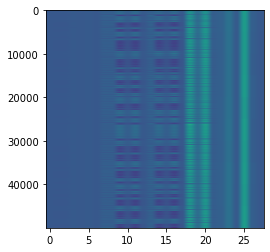

['1', 'x', 'y', 'z', 'sigma', 'rho', 'beta', 'x^2', 'x y', 'x z', 'x sigma', 'x rho', 'x beta', 'y^2', 'y z', 'y sigma', 'y rho', 'y beta', 'z^2', 'z sigma', 'z rho', 'z beta', 'sigma^2', 'sigma rho', 'sigma beta', 'rho^2', 'rho beta', 'beta^2']
[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.         -0.99991947  0.
   0.          0.          0.          0.99991904  0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.         -0.99854228  0.          0.          0.
   0.          0.          0.         -0.9997788   0.          0.99972127
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.99988313  0.         

In [3]:
lib=ps.PolynomialLibrary()
opt=ps.STLSQ(normalize_columns=False)
x=np.concatenate([np.concatenate([x_trains[i],u_trains[i]],axis=1) for i in range(len(x_trains))])
x_dot=np.concatenate([ps.differentiation.FiniteDifference()._differentiate(x_trains[i],dt) for i in range(len(x_trains))])
lib.fit(x)
mat=lib.transform(x)
plt.imshow(mat)
plt.gca().set_aspect(mat.shape[1]/mat.shape[0])
plt.show()
print(lib.get_feature_names(['x', 'y', 'z', 'sigma', 'rho', 'beta']))
opt.fit(mat,x_dot)
print(opt.coef_)
model = ps.SINDy(feature_library=lib,optimizer=opt,feature_names=['x', 'y', 'z', 'sigma', 'rho', 'beta'])
model.fit(x_trains, u=u_trains, t=dt, multiple_trajectories=True)
model.print()

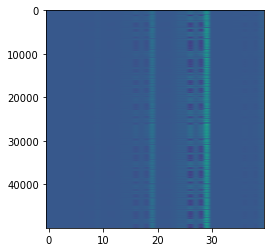

['1 1', '1 x', '1 y', '1 z', '1 x^2', '1 x y', '1 x z', '1 y^2', '1 y z', '1 z^2', 'sigma 1', 'sigma x', 'sigma y', 'sigma z', 'sigma x^2', 'sigma x y', 'sigma x z', 'sigma y^2', 'sigma y z', 'sigma z^2', 'rho 1', 'rho x', 'rho y', 'rho z', 'rho x^2', 'rho x y', 'rho x z', 'rho y^2', 'rho y z', 'rho z^2', 'beta 1', 'beta x', 'beta y', 'beta z', 'beta x^2', 'beta x y', 'beta x z', 'beta y^2', 'beta y z', 'beta z^2']
[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.         -0.99991947
   0.99991904  0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.         -0.99854228  0.          0.          0.
  -0.9997788   0.          0.          0.          0.       

In [4]:
lib=ps.ParameterizedLibrary()
opt=ps.STLSQ(normalize_columns=False)
x=np.concatenate([np.concatenate([x_trains[i],u_trains[i]],axis=1) for i in range(len(x_trains))])
x_dot=np.concatenate([ps.differentiation.FiniteDifference()._differentiate(x_trains[i],dt) for i in range(len(x_trains))])
lib.fit(x)
mat=lib.transform(x)
plt.imshow(mat)
plt.gca().set_aspect(mat.shape[1]/mat.shape[0])
plt.show()
print(lib.get_feature_names(['x', 'y', 'z', 'sigma', 'rho', 'beta']))
opt.fit(mat,x_dot)
print(opt.coef_)
model = ps.SINDy(feature_library=lib,optimizer=opt,feature_names=['x', 'y', 'z', 'sigma', 'rho', 'beta'])
model.fit(x_trains, u=u_trains, t=dt, multiple_trajectories=True)
model.print()